In [11]:
# load packages for analysis
import os
import ast
from cityseer.metrics import networks
from cityseer.tools import graphs, io
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
import seaborn as sns
from xml import etree
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
import shapely.wkt
import statsmodels.api as sm

In [12]:
os.getcwd()

'/Users/nikhildesai/Documents/Documents/NFI'

In [13]:
retail = gpd.read_file("analysis/data/cpt_retailpoints.gpkg")

In [14]:
ps = gpd.read_file("analysis/data/ODP/Parks/SL_PARK_HRTC_PARK.shp")

In [15]:
# Reproject to EPSG:3857 for accurate distance calculations in metres
ps = ps.to_crs(epsg=3857)
retail = retail.to_crs(epsg=3857)

In [16]:
# Buffer each public space by 500 metres
ps['geometry_buffered'] = ps.geometry.buffer(500)

# Spatial join: find retail points within each buffered public space
retail_within_buffer = gpd.sjoin(retail, ps.set_geometry('geometry_buffered'), how='inner')

# Count number of retail points per public space
retail_counts = retail_within_buffer.groupby('index_right').size()
ps['retail_count_500m'] = ps.index.map(retail_counts).fillna(0).astype(int)

In [17]:
ps.head()

,OBJECTID,PARK_NAME,LU_PARK_TY,ACS_ADR,PLAY_EQPM,SUB_AREA,SHAPE_Leng,SHAPE_Area,geometry,geometry_buffered,retail_count_500m
0,1625265,Disa Place Pos,12,Longueville Street,NO,4.2,236.733856,3472.532975,"POLYGON ((2054582.71 -4034568.04, 2054592.076 ...","POLYGON ((2054371.673 -4034114.76, 2054417.48 ...",30
1,1625266,Highfield Road Community Garden,15,Highfield Road,YES,4.3,90.777489,401.816197,"POLYGON ((2069414.165 -4031602.947, 2069425.96...","POLYGON ((2068925.722 -4031709.827, 2068917.56...",3
2,1625267,Mitchell Pos,12,De Duin Avenue,NO,4.4,510.783669,13477.945081,"POLYGON ((2070562.49 -4034281.783, 2070573.867...","POLYGON ((2070359.189 -4033824.98, 2070405.848...",1
3,1625268,Igiyogiyo Road Passageway,14,Igiyogiyo Road & M. Gigiby Road,NO,4.3,79.339137,229.556311,"POLYGON ((2070298.646 -4027765.235, 2070304.31...","POLYGON ((2069894.264 -4027471.168, 2069925.12...",2
4,1625269,Janet Avenue Passageway,14,Janet Avenue & Van Ryn Avenue,NO,4.2,156.529328,537.626529,"POLYGON ((2054521.331 -4031850.537, 2054525.59...","POLYGON ((2054286.259 -4032291.832, 2054244.04...",0


In [18]:
# Drop the buffer geometry (optional, for cleaner plotting)
ps = ps.drop(columns='geometry_buffered')

# Re-set the active geometry to original public space polygons
ps = ps.set_geometry('geometry')

# Clip extreme values if needed (optional: e.g. 99th percentile)
ps['retail_count_500m'] = ps['retail_count_500m'].clip(upper=ps['retail_count_500m'].quantile(0.99))

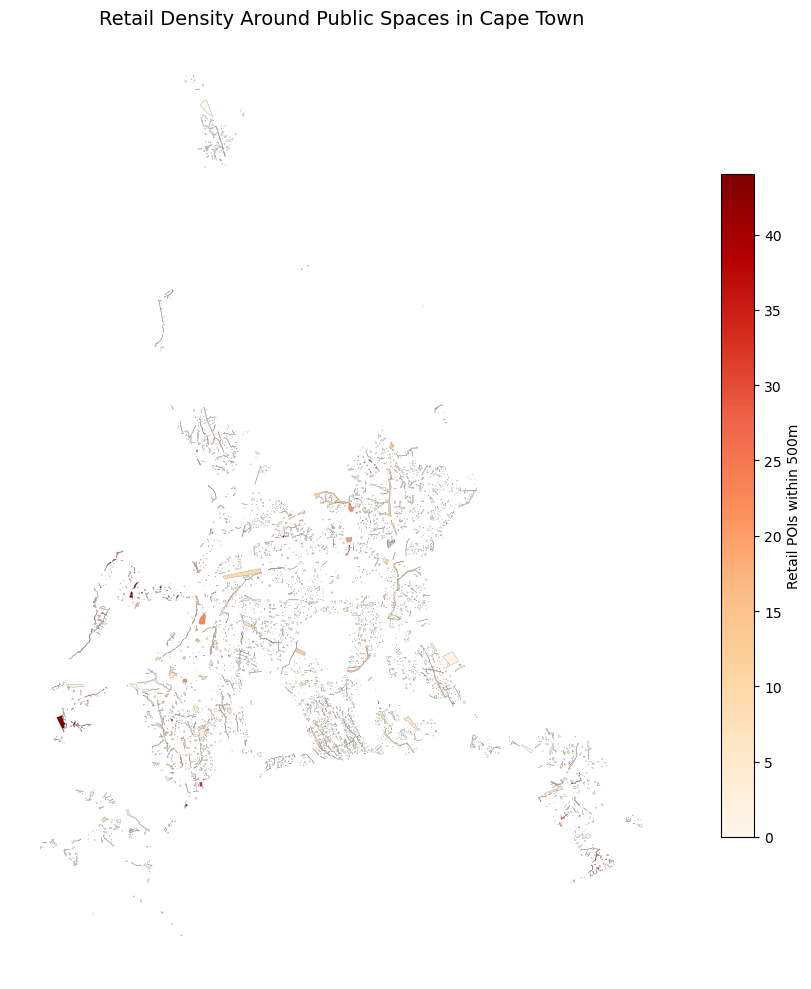

In [19]:
import matplotlib.pyplot as plt

# Plot public spaces coloured by retail density
fig, ax = plt.subplots(figsize=(10, 10))
ps.plot(column='retail_count_500m',
        ax=ax,
        cmap='OrRd',
        legend=True,
        edgecolor='grey',
        linewidth=0.2,
        legend_kwds={'label': "Retail POIs within 500m",
                     'shrink': 0.7})

ax.set_title("Retail Density Around Public Spaces in Cape Town", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# Save to GeoPackage for use in QGIS
ps.to_file("ps_retaildensity.gpkg", layer='public_spaces', driver="GPKG")

INFO:pyogrio._io:Created 5,929 records
